# Solving a problem with quantum computers

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector
backend = BasicAer.get_backend('qasm_simulator')

Generating random numbers from a variety of specific probability distributions is interesting, and so is implementing digital computer operations on a quantum computer so that multiple operations are performed simultaneously. However neither of these is enough to justify the hype around quantum computers. Let's now take a look at an example of something where quantum computers can significantly outperform digital computers. It's known as [Grover's algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm), and allows a quantum computer to take a function that might be performed on digital computers, and wrap it in some quantum goodness that quickly solves for it. "Solving for it" in this context means creating a probability distribution that is skewed in a controlled way so that the right answer comes up most often when measuring the qubits at the end.

Also, we will solve for a function of the type where it has one (or just a couple) of solutions, and where the approach to solve for it on a digital computer would be to "brute force" the answer by trying every possible solution to check if it works. On a quantum computer, there are some tricks to try the function fewer times, or even just once, and yet still figure out the solution. This demonstrates quantum advantage for using a quantum computer to solve problems of this type.

Functions of the type we're interested in, that have one specific solution, exist all over the place. So, this is a potentially highly useful application for quantum computers. For example, a function that checks a possible set of numbers to a particular [Sudoku puzzle](https://en.wikipedia.org/wiki/Sudoku) to confirm if it is a correct solution, a function that checks a password to see if it matches an encrypted password entry for a user, or a function that confirms the colour of a particular pixel in an image is correct for a given 3D scene with a particular set of objects and lighting. Many different problems can be rewritten in terms of a function that checks if an answer is correct.

However, before seeing how to do this on a quantum computer, we need to introduce a couple of new operations. 

### Z operation
The Z operation works on all pairs of rows in the state vector associated with different values of a particular qubit, and flips the sign on the second row of each pair. We can call it the "flip" operation. Let's have a quick look at an example.

In a two qubit scenario, if we start with an H(0) operator and an H(1) operator, as we did in the first notebook, we have the same value on each row of the state vector. If we then do a Z(0) followed by a Z(1), you can see the signs flip but the numbers otherwise stay the same.

| Qubits| Initial state vector | H(0) | H(1) | Z(0) | Z(1) |
| :- | :- | :- | :- | :- | :- |
| $\rvert00\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{2}$  | $\frac{1}{2}$  |
| $\rvert01\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | -$\frac{1}{2}$ | -$\frac{1}{2}$ |
| $\rvert10\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{2}$  | -$\frac{1}{2}$ |
| $\rvert11\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | -$\frac{1}{2}$ | $\frac{1}{2}$  |

We saw negative probabilities in the notebook where we introduced the RY operation, and here they are again. They are the key to how Grover's algorithm works.

Note that we could have created a Z operation out of the operations that we already have, using a neat trick. The Z operation produces the same result as using the H, X, and H operations in sequence. If you remember, H takes a pair of rows with values $a$ and $b$, and turns them into $\frac{a+b}{\sqrt{2}}$ and $\frac{a-b}{\sqrt{2}}$. X then swaps these, so performing H again results in $\frac{2a}{\sqrt{2}\times\sqrt{2}}$ and $\frac{-2b}{\sqrt{2}\times\sqrt{2}}$ which is $a$ and $-b$. However, Z is a common enough thing to want to do that it is useful to have it as a standalone operation rather than do H, X and H each time.

### CCZ operation
Similarly to CCX, the CCZ is "doubly constrained". In this case, it is a "doubly constrained flip" operation. Constrained to just those rows where the two specified qubits are $|1\rangle$, it flips the sign of the second row of all pairs where the third qubit is the only one changing. Since the second row of these pairs is also the row where the third qubit is $|1\rangle$, another way to think about this operation is flipping the sign of all rows where the three specified qubits are $|1\rangle$.

Here's an example of CCZ in practice:

| Qubits| Initial state vector | H(0) | H(1) | H(2) | CCZ(0, 1, 2) |
| :- | :- | :- | :- | :- | :- |
| $\rvert000\rangle$ ($\rvert0\rangle$) | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert001\rangle$ ($\rvert1\rangle$) | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert010\rangle$ ($\rvert2\rangle$) | $0.0$ | $0.0$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert011\rangle$ ($\rvert3\rangle$) | $0.0$ | $0.0$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert100\rangle$ ($\rvert4\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert101\rangle$ ($\rvert5\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert110\rangle$ ($\rvert6\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$ |
| $\rvert111\rangle$ ($\rvert7\rangle$) | $0.0$ | $0.0$ | $0.0$ | $\frac{1}{\sqrt{8}}$ | $-\frac{1}{\sqrt{8}}$ |


### Implementing a verifier
The other thing that Grover's algorithm needs is a function that verifies whether a value is a valid solution to some problem. All it needs to do is take a potential solution, and tell us "yes" or "no".

We can do this by considering some of the qubits to represent a proposed solution, and one other qubit to represent "yes" if it is $|1\rangle$ or "no" if it is $|0\rangle$. In the example implemented here, qubits 0 and 1 will represent potential solutions, and qubit 2 will represent the result of validating it.

On a digital computer, we would think about this as bits. We would implement some logical operations that take two bits representing potential solutions and return another bit with the validation result. As we saw in the last notebook, we can implement the deterministic operations of a digital computer on a quantum computer by using X, CX, CCX, etc. operations.

Let's say we want our verifier function to take state vectors where one of $|000\rangle$, $|001\rangle$, $|010\rangle$, or $|011\rangle$ rows has the value $1.0$ (100%), and only if it's the "right" one, will the state vector be changed so that the corresponding row where qubit 2 is $|1\rangle$ becomes $1.0$. For example, if $|011\rangle$ is the right solution, this would be implemented simply with the function CCX(0, 1, 2).

Firstly, let's use X operations to encode the value 3 into the state vector, by putting the value $1.0$ in the $|011\rangle$ ($|3\rangle$) row.

In [2]:
q = QuantumRegister(3)    # We want 3 qubits
algo1 = QuantumCircuit(q) # Readies us to construct an algorithm to run on the quantum computer

# Start in the |3> row
algo1.x(0)
algo1.x(1)

v1 = Statevector(algo1)
array_to_latex(np.vstack(v1.data))

<IPython.core.display.Latex object>

Now if we perform CCX(0, 1, 2), the values in $|011\rangle$ ($|3\rangle$) and $|111\rangle$ ($|7\rangle$) will be swapped, moving the $1.0$ value to the final row, where qubit 2 has a value of $|1\rangle$. Since we know that CCX is constrained to work only on these rows, we know that only where the $|011\rangle$ potential solution is given the $1.0$ value will the state vector be changed to have $1.0$ on a row where qubit 2 is $|1\rangle$. The other three potential solutions will result in no change.

In [3]:
algo1.ccx(0, 1, 2) # Apply CX operation, constrained to rows where qubit 0 and 1 are |1>, swapping qubit 2's rows
v2 = Statevector(algo1)
array_to_latex(np.vstack(v2.data))

<IPython.core.display.Latex object>

To create different verifier functions, we can use X operations and specify either qubit 0 or qubit 1. For example, to create a function that will answer "yes" for the potential solution $|01\rangle$ and "no" the other three potential solutions, we simply do X(1) before doing CCX(0, 1, 2). We will also do X(1) again after the CCX to "undo" the first X, and ensure the state vector has $1.0$ in the $|101\rangle$ ($|5\rangle$) row:

| Qubits| Initial state vector | X(1) | CCX(0, 1, 2) | X(1) |
| :- | :- | :- | :- | :- |
| $\rvert000\rangle$ ($\rvert0\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $\rvert001\rangle$ ($\rvert1\rangle$) | $1.0$ | $0.0$ | $0.0$ | $0.0$ |
| $\rvert010\rangle$ ($\rvert2\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $\rvert011\rangle$ ($\rvert3\rangle$) | $0.0$ | $1.0$ | $0.0$ | $0.0$ |
| $\rvert100\rangle$ ($\rvert4\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $\rvert101\rangle$ ($\rvert5\rangle$) | $0.0$ | $0.0$ | $0.0$ | $1.0$ |
| $\rvert110\rangle$ ($\rvert6\rangle$) | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $\rvert111\rangle$ ($\rvert7\rangle$) | $0.0$ | $0.0$ | $1.0$ | $0.0$ |

Implementing this in Qiskit:

In [4]:
# Verifies that a proposed solution is correct only when it is |10>
def add_verify(algo):
    algo.x(1)
    algo.ccx(0, 1, 2)
    algo.x(1)

In [5]:
algo2 = QuantumCircuit(q) # Readies us to construct an algorithm to run on the quantum computer

# Ensure the state vector has 100% in the |001> row
algo2.x(0) 

add_verify(algo2) # Add the verify function to the algorithm
v3 = Statevector(algo2)
array_to_latex(np.vstack(v3.data))

<IPython.core.display.Latex object>

However, we need to modify the verifier function a little first. We are going to apply the H operation on the result qubit (qubit 2) before running the function, and then again afterwards.

This is a little trick that turns an X operation into a Z operation. So, the CCX operation effectively becomes like a CCZ operation. And yes, the verifier function could have just been written with a CCZ instead of a CCX and we could skip the H operations, but digital computer operations don't use Z type operations, and this way the algorithm is more general.

In [6]:
# Flips the sign of the row corresponding to the outcome that the verify function would indicate is correct
def add_verify_with_h(algo):
    algo.h(2)
    add_verify(algo)
    algo.h(2)

This version of the function will now flip the sign of the state vector row with the answer. Unfortunately, we can't stop here with the job done, because in practice we can't read the state vector out of the quantum computer. All we can do is take measurements of the qubits, and while we can have a negative value in a row of a state vector, we won't see a negative probability appear in measurements.

Grover's algorithm is about amplifying the negative row so it will have a higher probability in the measurements.

### Grover's algorithm
Normally the verification function will be quite complicated, and difficult to figure out from just looking at it. Our verification function is simple, but that's fine for learning how Grover's algorithm works.

The basic strategy for using Grover's algorithm is to:
1. Prepare the state vector so it has the same value on every row, i.e. no row has a zero value.
2. Apply the verification function, which will flip the sign of the row corresponding to the right answer.
3. Amplify the negative rows compared to the non-negative rows.

Then we measure the qubits, and the most likely result should be the right answer. For larger numbers of qubits, the steps 2 and 3 will typically be repeated to make the right answer clearer, but we shouldn't need to do that for our example.

We've already defined the verification function, but here's the state preparation function:

In [7]:
# Creates a uniform probability distribution across the state vector
def add_prepare(algo):
    algo.h(0)
    algo.h(1)
    algo.h(2)

It is just the approach to creating a uniform probability distribution that we saw in the first notebook.

We can see how the verification function just flips the sign of the answer row ($|101\rangle$) when given a state vector with $\frac{1}{\sqrt{8}}$ values in all of its rows:

In [8]:
algo3 = QuantumCircuit(q) # Readies us to construct an algorithm to run on the quantum computer
add_prepare(algo3)        # Add the operations to prepare the state vector for solving the function
add_verify_with_h(algo3)  # Add the sign-flipping version of the verify function to the algorithm
v4 = Statevector(algo3)
array_to_latex(np.vstack(v4.data))

<IPython.core.display.Latex object>

The amplification function requires a bit of explanation. 

The idea is to make everything a bit more negative, and because one row is already negative, that row becomes much more negative than the other rows. As the probability of the outcome of a measurement being a given row is equal to the square of the value of that row, it doesn't matter than the values are negative. The row that is more negative than the other rows will end up becoming a more likely outcome.

The workhorse of the procedure is the H operation. As we discussed in the first notebook, it is like a "half" operation, where it works on all pairs of rows that differ only by a specific qubit, and turns the first of these into the sum of the pairs divided by the root of a half, and the second into the difference of the pairs divided by the root of a half.

There are two observations worth noting here. Firstly, it puts the sums of the pairs into the first row, i.e. the row where the specific qubit is $|0\rangle$. Secondly, it is its own inverse, i.e. that it you perform two identical H operations in sequence, the second operation undoes the first one.

Using these two observations, the amplification function applies the H operation for each of the qubits in turn, resulting in all rows being summed into the first row of the state vector, i.e. corresponding to $|000\rangle$, although this sum will be divided by the root of 8, which is the result of applying $\frac{1}{\sqrt{2}}$ in the calculations three times. However, this row will be a large, positive value.

Then the amplification function flips the sign on the $|000\rangle$ row, making it a large, negative value. Lastly, the H operation is applied for each qubit in turn, reversing the earlier H operations, but spreading the amount "taken" from the $|000\rangle$ row across all of the other rows.

Let's see it in action. Firstly, let's apply H for each qubit. We can do this by reusing the prepare function:

In [9]:
add_prepare(algo3)
v5 = Statevector(algo3)
array_to_latex(np.vstack(v5.data))

<IPython.core.display.Latex object>

After the verify function was performed, all rows were $\frac{1}{\sqrt{8}}$, except for the solution row which was negative. The sum of all rows is $\frac{6}{\sqrt{8}}$ and this value divided by $\sqrt{8}$ is $\frac{3}{4}$, which is what we've ended up with in row $|000\rangle$ after the first part of the amplification procedure.

Next we flip the sign on that row so it becomes negative. We can do this by using the X operation for each qubit, to reverse the order of the state vector. On a digital computer, to reverse a vector like this, you'd need to perform an operation for each row in the first half of the vector, swapping it with its counterpart row in the second half of the vector. Quantum computers are much more efficient.

X(0) swaps groups of rows separated by one row, X(1) swaps groups of rows separated by two rows, and X(2) swaps groups of rows separated by four rows. Once we've performed each of these, the state vector has been reversed:

In [10]:
# Reverses the rows of the state vector
def add_reverse(algo):
    algo.x(0)
    algo.x(1)
    algo.x(2)

Using this reverse routine, we can following it by using CCZ to flip the sign on row $|111\rangle$, then reverse the state vector again to put the state vector back in the original order.

In [11]:
add_reverse(algo3) # Add the operations to reverse the state vector
algo3.ccz(0, 1, 2) # Apply the CCZ operation to flip the sign on row |111>
add_reverse(algo3) # Add the operations to reverse the state vector again, putting it back in the right order
v6 = Statevector(algo3)
array_to_latex(np.vstack(v6.data))

<IPython.core.display.Latex object>

Note that in flipping the sign on row $|000\rangle$, we have deducted an amount equal to $\frac{6}{4}$ (or $\frac{3}{2}$) from this row. This reduction will now be spread back across all the rows by using the H operation for each qubit again. 

In [12]:
add_prepare(algo3)
v7 = Statevector(algo3)
array_to_latex(np.vstack(v7.data))

<IPython.core.display.Latex object>

The reduction by $\frac{3}{2}$ has been divided by $\sqrt{8}$ again, so the difference between these values and the ones after the verify function is just $\frac{3}{\sqrt{32}}$. All of the rows that were $\frac{1}{\sqrt{8}}$ are now $-\frac{1}{\sqrt{32}}$, and the single row that was $-\frac{1}{\sqrt{8}}$ is now $-\frac{5}{\sqrt{32}}$. The visualisation here in the notebook probably doesn't show it, and just shows $-0.17678$ (or similar) for all rows except one that shows $-0.88388$ (or similar).

Now that we've worked through the operation of the amplify function, we can define it as a Python function:

In [13]:
# Amplifies the row with a negative value to become more negative
def add_amplify(algo):
    add_prepare(algo)
    add_reverse(algo)
    algo.ccz(0, 1, 2)
    add_reverse(algo)
    add_prepare(algo)

Let's now see the whole thing in action, and what gets measured at the end.

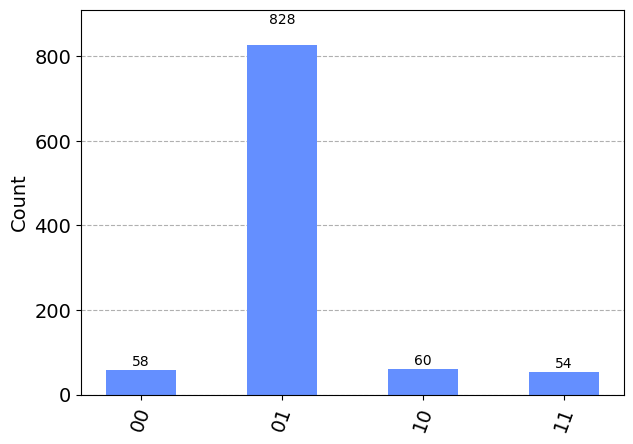

In [14]:
c = ClassicalRegister(2)     # The solution at the end has only 2 bits
algo4 = QuantumCircuit(q, c) # Readies us to construct an algorithm to run on the quantum computer

add_prepare(algo4)           # Step 1 of Grover's: prepare the state vector
add_verify_with_h(algo4)     # Step 2 of Grover's: apply the verify function and flip the solution row negative
add_amplify(algo4)           # Step 3 of Grover's: amplify negative rows

algo4.measure(q[0:2], c)     # Measure the two qubits 0 and 1, and get some bits
result = execute(algo4, backend, shots=1000).result()    # Run this all 1,000 times
plot_histogram(result.get_counts(algo4))                 # Show a histogram of the results

You can go back and set up the verify function differently, and you'll see that the algorithm will still reveal the correct solution in the measurements.

In this way, the quantum computer hasn't needed to brute force the answer by trying the verification function over and over again until it finds the answer. The fact that the verification function can be used to make a row in the state vector negative was enough to allow this negative value to be amplified, and set up a probability distribution that makes the answer pop out more often in the measurements.

As I mentioned at the start, it may be that the 
```
add_verify_with_h(algo4)
add_amplify(algo4)
```
steps need to be repeated as the number of qubits increases. However, it won't need to be done as frequently as once per qubit, so it will continue to be more efficient than the brute force approach that a digital computer has to use.

### In conclusion
We added another two operations to our set, and have seen how to use them on a quantum computer to figure out the solution to a problem giving the digital computing function that verifies solutions to that problem. Here is the complete set of operations over these four notebooks:

| Operation | Short-hand description | Specified by | Detailed description |
| :- | :- | :- | :- |
| H | "half" | 1 qubit | For all pairs of rows that differ only by the value of a specific qubit, replace the first row value into a new value that is the *sum* of the original values divided by $\sqrt{2}$, and the second row value into the *difference* between the original values divided by $\sqrt{2}$. |
| CX | "constrained swap" | 2 qubits | For all pairs of rows where the first qubit specified is in the $\rvert1\rangle$ state, and where otherwise the rows differ only by the value of the second qubit specified, swap the rows in the pair. |
| RY | "relative swap" | 1 angle and 1 qubit | For all pairs of rows that differ only by the value of a specific qubit, swap a fraction $f$ of the value from the first row to the second, and bring the opposite fraction (i.e. $1-f$) from the second row but with the sign flipped, where $f$ is specified as the angle $2 \times arcsin(\sqrt{f})$. If $f$ is $1.0$, the angle will be $\pi$. |
| X | "swap" | 1 qubit | For all pairs of rows that differ only by the value of a specific qubit, swap the values in the pair. |
| CCX | "doubly constrained swap" | 3 qubits | For all pairs of rows where both the first and second qubit specified are in the $\rvert1\rangle$ state, and where otherwise the rows differ only by the value of the third qubit specified, swap the rows in the pair. |
| Z | "flip" | 1 qubit | For all pairs of rows that differ only by the value of a specific qubit, flip the sign on the second row of each pair. |
| CCZ | "doubly constrained flip" | 3 qubits | For all pairs of rows where both the first and second qubit specified are in the $\rvert1\rangle$ state, and where otherwise the rows differ only by the value of the third qubit specified, flip the sign on the second row of each pair. |

That's all for now. Hope you've enjoyed working along with me in seeing how quantum computers can perform computation by changing the probabilities of the different possible outcomes of their qubits, and how often this approach allows quantum computers to solve a problem more efficiently than a digital computer.